In [28]:
%load_ext autoreload
%autoreload 2

import random
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

import cpn_model
import config
import michaels_load
import mRNN
import stim_model
import utils 


OBSERVER_TYPE = "gaussian"
STIMULATION_TYPE = "gaussianExp"
CPN_ACTIVATION_TYPE = "Tanh"
EN_ACTIVATION_TYPE = "Tanh"
LESION_TYPE = "connection"
OBS_OUT_DIM = 20
NUM_STIM_CHANNELS = 92
STIM_SIGMA = 0.075
BATCH_SIZE = 128

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, recovery_mode, recovery_str, \
        run_type_str, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type=LESION_TYPE,
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=NUM_STIM_CHANNELS,
                                              stim_sigma=STIM_SIGMA,
                                              obs_out_dim=OBS_OUT_DIM)


CPN_DATA_DIR = "cpn"
EN_DATA_DIR = "en"
MRNN_DIR = "mrnn"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Set up the Michaels mRNN

# Our stimulation model
stimulus.reset(batch_size=BATCH_SIZE)

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       stimulus=stimulus)



In [30]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path())

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader_cpn = DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True
)

loader_en = DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True
)

# Loader produces lists of len 2:
#  (input of batch, output of batch); which is:
#  (shape(<=batch_size, time, 21), shape(<=batch_size, time, 50))

torch.Size([341, 21])
torch.Size([1, 341, 50])
torch.Size([1, 341, 50])


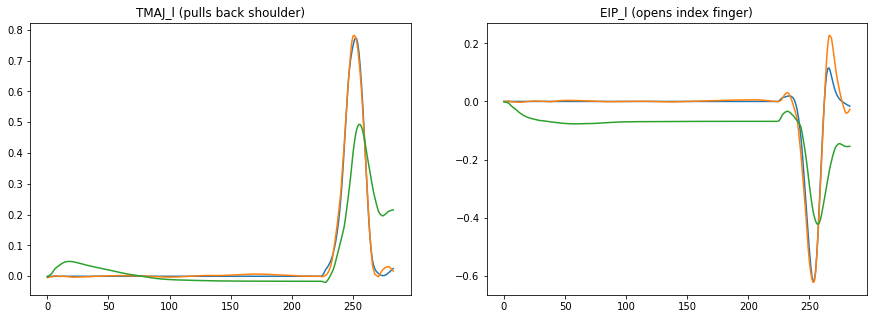

In [4]:
# Just some choice of examples, for graphical comparison
example_idx = random.randrange(len(dataset))
example_din, _, trial_len, example_dout = dataset[example_idx]

mike.set_lesion(None)
mike.reset()
reference_pred_healthy = mike.unroll(example_din.T)

# Lesion the network as we specified above
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()


print(example_din.shape)
print(reference_pred_healthy.shape)
print(reference_pred_lesioned.shape)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("TMAJ_l (pulls back shoulder)")
ax[0].plot(example_dout[:trial_len, 7].detach().numpy())
ax[0].plot(reference_pred_healthy[0, :trial_len, 7].detach().numpy())
ax[0].plot(reference_pred_lesioned[0, :trial_len, 7].detach().numpy())
ax[1].set_title("EIP_l (opens index finger)")
ax[1].plot(example_dout[:trial_len, 45].detach().numpy())
ax[1].plot(reference_pred_healthy[0, :trial_len, 45].detach().numpy())
ax[1].plot(reference_pred_lesioned[0, :trial_len, 45].detach().numpy())

plt.show()

tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0207, grad_fn=<MseLossBackward>)


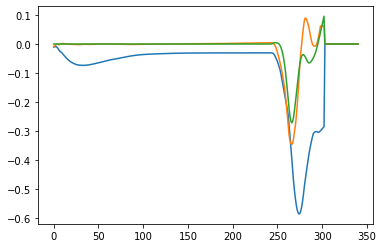

In [5]:
# Now a numerical comparison
comp_loss = torch.nn.MSELoss()

loader_comp = DataLoader(
  dataset, batch_size=len(dataset), shuffle=True
)
for s in loader_comp:
    din, trial_end, _, dout = s

comp_preds_healthy = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
mike.set_lesion(None)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_healthy[:, tidx, :] = p[:, :]
comp_preds_healthy = utils.trunc_to_trial_end(comp_preds_healthy, trial_end)
comp_loss_healthy = comp_loss(comp_preds_healthy, dout)
print(comp_loss_healthy)

comp_preds_lesioned = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_lesioned[:, tidx, :] = p[:, :]
comp_preds_lesioned = utils.trunc_to_trial_end(comp_preds_lesioned, trial_end)
comp_loss_lesioned = comp_loss(comp_preds_lesioned, dout)
print(comp_loss_lesioned)


plt.plot(comp_preds_lesioned[0, :, 20].detach().numpy())
plt.plot(comp_preds_healthy[0, :, 20].detach().numpy())
plt.plot(dout[0, :, 20].detach().numpy())
plt.show()


In [6]:
def unroll(cpn, mike, en, din, trial_end, observer,
           drop_module_idx=None, retain_stim_grads=False):
    batch_size = din.shape[0]
    steps = din.shape[1]
    obs_dim = 3 * observer.out_dim
    
    stims = []
    preds = torch.zeros(batch_size, steps - 1, en.out_dim)
    actuals = torch.zeros(batch_size, steps - 1, en.out_dim)
    
    # This is the actual, which EN predicts
    mike_out = mike(din[:, 0, :].T)
    
    for tidx in range(steps - 1):
        obs = mike.observe(observer, drop_module_idx=drop_module_idx)
        new_obs_cpn = torch.cat(tuple([torch.tensor(o).float() for o in obs]),
                            axis=1)
        new_obs_en = torch.tensor(obs[0]).float()

        # cpn recieves (obs, trial_end)
        cpn_in = torch.cat((new_obs_cpn, trial_end[:, tidx, :]), axis=1)
        # output is (batch_size, num_stim_channels)
        new_stim = cpn(cpn_in)
        assert new_stim.shape == (batch_size, mike.stimulus.num_stim_channels)
        if retain_stim_grads:
            new_stim.retain_grad()
        stims.append(new_stim)
            
        # en receives (obs, stims, trial_end)
        en_in = torch.cat((new_obs_en, new_stim, trial_end[:, tidx, :]), axis=1)
        cur_pred = en(en_in)
        preds[:, tidx, :] = cur_pred[:, :]
            
        # new_stim will be cloned in here, to prevent accidentally backprop-ing
        # through the "brain", aka mike.
        mike.stimulate(new_stim)
                
        # Note that 'preds' lags 'actual' by a time step, hence
        # 'pred' is a prediction of the actual en activity
        mike_out = mike(din[:, tidx + 1, :].T)
        actuals[:, tidx, :] = mike_out[:, :]
        
    actuals = utils.trunc_to_trial_end(actuals, trial_end[:, :-1, :])
    preds = utils.trunc_to_trial_end(preds, trial_end[:, :-1, :])
    return actuals, preds, stims 

In [22]:
def train_an_en(mike, observer, cpn, data_loader, en=None,
                last_loss=1, drop_module_idx=None):
    # the last EN we were working on training, for easy access
    global recent_en
    
    obs_dim = observer.out_dim * 1
    # Stim: mike.stimulus.num_stim_channels
    # +1 for trial_end
    en_in_dim = obs_dim + mike.stimulus.num_stim_channels + 1
    if en is None:
        en = stim_model.StimModelLSTM(en_in_dim, mike.output_dim,
                num_neurons=en_in_dim+30, activation_func=torch.nn.Tanh)
        recent_en = en
    vl = torch.tensor(1.0)
    opt_en = AdamW(en.parameters(), lr=9e-3, weight_decay=0.04)
    
    cpn_reset_cadence = 10


    checkpoint_eidx = 0
    eidx = -1
    while True:
        
        for batch in data_loader:            
            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
            eidx += 1
            opt_en.zero_grad()
            opt_en.zero_grad()
            mike.reset()
            en.reset()
            cpn.reset()
            loss = torch.nn.MSELoss()
            
            for p in opt_en.param_groups:
                #if eidx < 3:
                #    p['lr'] = 2e-2
                #else:
                if vl.item() < 0.0007:
                    p['lr'] = 1e-4
                elif vl.item() < 0.005:
                    p['lr'] = 3e-3
                else:
                    p['lr'] = 9e-3
            
            if (eidx % cpn_reset_cadence) == 0:
                cpn_noise = cpn_model.CPNNoiseyLSTMCollection(cpn, noise_var=(last_loss))
                cpn_noise.setup(BATCH_SIZE)
                opt_cpnn = AdamW(cpn_noise.parameters(), lr=1e-4)
            else:
                opt_cpnn.zero_grad()
                cpn_noise.reset()

        
            # Just in case...
            for param in mike.parameters():
                param.requires_grad=False

            actual, preds, _ = unroll(cpn_noise, mike, en, din, trial_end,
                                      observer, drop_module_idx=drop_module_idx)
            
            # Update our noisy cpn
            target_loss = loss(preds, dout[:, 1:, :])
            target_loss.backward(retain_graph=True)
            opt_cpnn.step()
            opt_en.zero_grad()
        
            # Update en
            rl = loss(preds, actual)
            rl.backward()
            opt_en.step()
        
            # Verify against the actual CPN
            mike.reset()
            en.reset()
            cpn.reset()
            loss = torch.nn.MSELoss()
            actual_val, preds_val, _ = unroll(cpn, mike, en, din,
                                              trial_end, observer,
                                              drop_module_idx=drop_module_idx)
           
            vl = loss(preds_val, actual_val)
            print("en", eidx, rl.item(), "val:", vl.item())
                    
            if torch.isnan(vl) or torch.isinf(vl) or vl.item() > 1.5 or (eidx - checkpoint_eidx) > 5000:
                # Emergency eject button
                en = stim_model.StimModelLSTM(en.in_dim, en.out_dim, num_neurons=en.num_neurons,
                                       activation_func=en.activation_func_t)
                recent_en = en
                opt_en = AdamW(en.parameters(), lr=1e-3, weight_decay=0.04)
                checkpoint_eidx = eidx
                
            if vl.item() < max(0.02 * last_loss, 5e-4) and eidx > 100:
                done = True
                break
            else:
                done = False
                
        if done:
            break
            
    opt_en.zero_grad()
    return en

In [24]:
obs_dim = observer.out_dim * 3
# +1 for trial_end
cpn_in_dim = obs_dim + 1
cpn = cpn_model.CPNModelLSTM(cpn_in_dim, mike.stimulus.num_stim_channels,
                             num_neurons=150, activation_func=torch.nn.Tanh)

#cpn.load_state_dict(torch.load('latest_cpn_F5condrop_obs20_stim92_nn150'))

# Up to 0.001:
#opt_cpn = AdamW(cpn.parameters(), lr=1e-4)

# 0.0007
#opt_cpn = AdamW(cpn.parameters(), lr=1e-5)

opt_cpn = AdamW(cpn.parameters(), lr=5e-6)

loss = torch.nn.MSELoss()
rli = 1

cpn_losses = []
pred_losses = []
real_losses = []
super_epoch_count = 0
en = recent_en

eidx = -1
while True:       
    super_epoch_count += 1
    
    for param in cpn.parameters():
        param.requires_grad=False
    
    if super_epoch_count == 0:
        en = train_an_en(mike, observer, cpn, loader_en, en=en, last_loss=rli)
    else:
        #if super_epoch_count > 1:
        en = train_an_en(mike, observer, cpn, loader_en, last_loss=rli)
    
    for param in cpn.parameters():
        param.requires_grad=True
    for param in en.parameters():
        param.requires_grad=False
    for param in mike.parameters():
        param.requires_grad=False
    
        
    recent_losses = []
    num_regressed = 0
    while True:
        for batch in loader_cpn:
            eidx += 1
            opt_cpn.zero_grad()
            cpn.reset()
            en.reset()
            mike.reset()
            
            if rli > 0.02:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-4
            elif rli <= 0.015:
                for p in opt_cpn.param_groups:
                    #p['lr'] = 1e-5
                    p['lr'] = 1e-4
            elif rli <= 0.0125:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-5
                    #p['lr'] = 5e-6
            elif rli <= 0.01:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-5
                    #p['lr'] = 1e-6
            
            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
    
            actuals, preds, stims = unroll(cpn, mike, en, din, trial_end, observer,
                                           retain_stim_grads=True)
            preds.retain_grad()
            
            rl = loss(preds, dout[:, 1:, :])
            rli = rl.item()
            rl.backward()  
            
            cpn_losses.append(rli)

            real_loss = torch.nn.MSELoss()(actuals, dout[:, 1:, :]).item()
            real_losses.append(real_loss)
                        
            pred_loss = torch.nn.MSELoss()(preds, actuals).item()
            pred_losses.append(pred_loss)
            
            print("cpn", eidx, rl.item(),
                  "en loss:", pred_loss,
                  "actual task loss:", real_loss)
            recent_losses.append(real_loss)
            
            torch.save(cpn.state_dict(), "latest_cpn_F5condrop_obs20_stim92_nn150")
            torch.save(en.state_dict(), "latest_en")
            if real_loss == min(recent_losses) and real_loss < 0.01:
                torch.save(cpn.state_dict(), "min_cpn_F5condrop_obs20_stim92_nn150")
                                                          
            bail = False
            done = False
            # Done
            if rli < 1e-5:
                bail = True
                done = True
                break
                
            if utils.loss_regressed(recent_losses):
                num_regressed += 1
            else:
                num_regressed = 0
                
            if num_regressed == 2:
                bail = True
                

            if len(recent_losses) > 7:
                prev = None
                num_reg = 0
                for l in recent_losses[-7:]:
                    if prev is not None and l > prev:
                        num_reg += 1
                        
                prev = l
                if num_reg > 3 or pred_loss > max(real_loss / 13, 9e-4):
                    bail = True
                    break
                
            opt_cpn.step()
                
            if bail:
                break
                
        if bail:
            break
            
    if done:
        break


# Best with trial ends not trunc'd 0.0076


en 0 0.3039172291755676 val: 0.019866308197379112
en 1 0.203079491853714 val: 0.03604014590382576
en 2 0.17599858343601227 val: 0.4525281488895416
en 3 0.2731335163116455 val: 0.05303698033094406
en 4 0.14973394572734833 val: 0.030057840049266815
en 5 0.14971603453159332 val: 0.029563656076788902
en 6 0.16470082104206085 val: 0.02568974159657955
en 7 0.13712430000305176 val: 0.023236867040395737
en 8 0.13903987407684326 val: 0.024176033213734627
en 9 0.12370510399341583 val: 0.03225797042250633
en 10 0.11194893717765808 val: 0.03819753974676132
en 11 0.11379159241914749 val: 0.03529795631766319
en 12 0.10322728753089905 val: 0.03214223310351372
en 13 0.10541286319494247 val: 0.030527127906680107
en 14 0.09859015792608261 val: 0.027264989912509918
en 15 0.09424098581075668 val: 0.024834943935275078
en 16 0.09455523639917374 val: 0.022206084802746773
en 17 0.09209617227315903 val: 0.020838452503085136
en 18 0.09577085822820663 val: 0.01937846466898918
en 19 0.08678826689720154 val: 0.017

en 41 0.0041409763507544994 val: 0.0035674029495567083
en 42 0.003962972667068243 val: 0.003425786504521966
en 43 0.003792456118389964 val: 0.0033225840888917446
en 44 0.003885985817760229 val: 0.0033440100960433483
en 45 0.004090521950274706 val: 0.0034746781457215548
en 46 0.004123623948544264 val: 0.003391943173483014
en 47 0.0039932639338076115 val: 0.003379269503057003
en 48 0.0037768222391605377 val: 0.003353616688400507
en 49 0.003698633750900626 val: 0.0033042700961232185
en 50 0.003814741736277938 val: 0.0032519185915589333
en 51 0.0037385981995612383 val: 0.0033573093824088573
en 52 0.003640602109953761 val: 0.0032737997826188803
en 53 0.0038364173378795385 val: 0.0032938981894403696
en 54 0.0037652947939932346 val: 0.003216993063688278
en 55 0.003931040875613689 val: 0.0032432186417281628
en 56 0.00371713493950665 val: 0.0031082455534487963
en 57 0.0037285219877958298 val: 0.0032799243927001953
en 58 0.003670820500701666 val: 0.0030455966480076313
en 59 0.0036364912521094084

en 191 0.000927206187043339 val: 0.0006230603903532028
en 192 0.0009294874616898596 val: 0.0006126257940195501
en 193 0.0009153720457106829 val: 0.0006117038428783417
en 194 0.0009631454013288021 val: 0.0006265288684517145
en 195 0.0009744256385602057 val: 0.0006391839706338942
en 196 0.000933311996050179 val: 0.0006432209629565477
en 197 0.000964865495916456 val: 0.0006396372336894274
en 198 0.0009290074813179672 val: 0.000600882398430258
en 199 0.000903464388102293 val: 0.0005872461479157209
en 200 0.0008954796940088272 val: 0.000612057454418391
en 201 0.0009105019271373749 val: 0.0005971778882667422
en 202 0.0009419213747605681 val: 0.000620390463154763
en 203 0.0009999979520216584 val: 0.0006298275548033416
en 204 0.0008720832993276417 val: 0.0005782829248346388
en 205 0.0009196560131385922 val: 0.0006127602537162602
en 206 0.0008958394755609334 val: 0.0006106597138568759
en 207 0.0009971983963623643 val: 0.000648472283501178
en 208 0.000949855602812022 val: 0.0006171173881739378
e

en 339 0.0009167949901893735 val: 0.0005570456851273775
en 340 0.0008737135212868452 val: 0.0005757114267908037
en 341 0.0008500278927385807 val: 0.0005577609408646822
en 342 0.0008885250426828861 val: 0.0005630328087136149
en 343 0.0008411731687374413 val: 0.0005700369947589934
en 344 0.0008568675839342177 val: 0.0005554715753532946
en 345 0.0008263245108537376 val: 0.0005687482189387083
en 346 0.0008570945356041193 val: 0.000562933913897723
en 347 0.0008532729698345065 val: 0.0005698587046936154
en 348 0.0008300376357510686 val: 0.000554302183445543
en 349 0.0007966748671606183 val: 0.0005597000708803535
en 350 0.0009596272720955312 val: 0.0005671605467796326
en 351 0.0009057525894604623 val: 0.0005644001066684723
en 352 0.0008465423015877604 val: 0.0005357566406019032
en 353 0.0008838922949507833 val: 0.0005904572317376733
en 354 0.0008626756025478244 val: 0.0005412001046352088
en 355 0.0008888492593541741 val: 0.0005786999827250838
en 356 0.0008839287329465151 val: 0.00054950709454

en 16 0.011796857230365276 val: 0.012009674683213234
en 17 0.012279392220079899 val: 0.012383622117340565
en 18 0.012497480027377605 val: 0.01225210539996624
en 19 0.012858208268880844 val: 0.012388942763209343
en 20 0.012547115795314312 val: 0.012037289328873158
en 21 0.012339334934949875 val: 0.012011264450848103
en 22 0.01200865488499403 val: 0.011575675569474697
en 23 0.012166649103164673 val: 0.0115900207310915
en 24 0.01162236463278532 val: 0.011267365887761116
en 25 0.011431674472987652 val: 0.01114727184176445
en 26 0.011398189701139927 val: 0.011056064628064632
en 27 0.011438983492553234 val: 0.011090482585132122
en 28 0.010989573784172535 val: 0.010764735750854015
en 29 0.01140884030610323 val: 0.011001601815223694
en 30 0.011086025275290012 val: 0.010804707184433937
en 31 0.010923759080469608 val: 0.010551831685006618
en 32 0.010786185041069984 val: 0.010341632179915905
en 33 0.010811380110681057 val: 0.010352897457778454
en 34 0.010511196218430996 val: 0.010001574642956257


en 168 0.00216485233977437 val: 0.0019579974468797445
en 169 0.002478049835190177 val: 0.0021668141707777977
en 170 0.0021500608418136835 val: 0.00195210799574852
en 171 0.0021528047509491444 val: 0.0019988727290183306
en 172 0.0023227643687278032 val: 0.001962310401722789
en 173 0.0021298720967024565 val: 0.0019232436316087842
en 174 0.0020410686265677214 val: 0.0018115837592631578
en 175 0.002166425809264183 val: 0.0019039660692214966
en 176 0.002042583655565977 val: 0.0017697106814011931
en 177 0.001963720191270113 val: 0.0018094058614224195
en 178 0.0019312226213514805 val: 0.0017367209075018764
en 179 0.00205390527844429 val: 0.0018102457979694009
en 180 0.0018291993765160441 val: 0.0015778647502884269
en 181 0.0018873834051191807 val: 0.00168330199085176
en 182 0.002027177019044757 val: 0.0017621321603655815
en 183 0.0019194197375327349 val: 0.0017373940208926797
en 184 0.0018240533536300063 val: 0.0015082074096426368
en 185 0.0018678456544876099 val: 0.0016354105900973082
en 186

en 316 0.0007672854699194431 val: 0.000612736155744642
en 317 0.000785591546446085 val: 0.0006526793586090207
en 318 0.0007583451806567609 val: 0.0006356887170113623
en 319 0.000766991637647152 val: 0.0006210198043845594
en 320 0.0007715970277786255 val: 0.0006416647229343653
en 321 0.0007923579541966319 val: 0.0006242042290978134
en 322 0.000752802996430546 val: 0.0006279212539084256
en 323 0.0007525520632043481 val: 0.0006209959392435849
en 324 0.0007877127500250936 val: 0.0006292123580351472
en 325 0.0007719366694800556 val: 0.0005914741777814925
en 326 0.0007701272261328995 val: 0.0006492285174317658
en 327 0.0007400359027087688 val: 0.0006368225440382957
en 328 0.0007422505877912045 val: 0.0006127844098955393
en 329 0.0008322662906721234 val: 0.0006696383934468031
en 330 0.0007146768039092422 val: 0.0005844337283633649
en 331 0.0007605168502777815 val: 0.0006350221810862422
en 332 0.0007880418561398983 val: 0.0006551937549374998
en 333 0.0007572651375085115 val: 0.0005844175466336

en 464 0.0007292857044376433 val: 0.0005798072670586407
en 465 0.0007506230031140149 val: 0.0005901728291064501
en 466 0.0007028066902421415 val: 0.0005645724013447762
en 467 0.0007725163013674319 val: 0.0006249947473406792
en 468 0.0007151266327127814 val: 0.0006028390489518642
en 469 0.0007445563096553087 val: 0.000570654112379998
en 470 0.0007157380459830165 val: 0.0005771090509369969
en 471 0.0007298730779439211 val: 0.0006060892483219504
en 472 0.0007796928402967751 val: 0.0006044171750545502
en 473 0.0007044917438179255 val: 0.0005828656139783561
en 474 0.0007014425355009735 val: 0.0005639758892357349
en 475 0.0007625020807608962 val: 0.0005985116004012525
en 476 0.0007138728979043663 val: 0.0005680288304574788
en 477 0.0007035445887595415 val: 0.0005706824595108628
en 478 0.0007613401394337416 val: 0.0006039355648681521
en 479 0.0007523834356106818 val: 0.0006020498112775385
en 480 0.0007550993468612432 val: 0.0005955364904366434
en 481 0.000732857792172581 val: 0.00060384377138

en 611 0.0007318371208384633 val: 0.000579654355533421
en 612 0.0007027651299722493 val: 0.0005540878628380597
en 613 0.0006633531884290278 val: 0.0005246769287623465
en 614 0.0006869153585284948 val: 0.0005590709042735398
en 615 0.0006641494110226631 val: 0.0005456531653180718
en 616 0.0007182119297794998 val: 0.0005525893648155034
en 617 0.0006707182619720697 val: 0.0005301592755131423
en 618 0.0006797030800953507 val: 0.0005592407542280853
en 619 0.0006893989630043507 val: 0.0005363727686926723
en 620 0.0006881024455651641 val: 0.0005529533955268562
en 621 0.0006294261547736824 val: 0.0005045908619649708
en 622 0.0007288289489224553 val: 0.0005850787274539471
en 623 0.0006668298738077283 val: 0.0005299639306031168
en 624 0.0006709536537528038 val: 0.0005132609512656927
en 625 0.000683331280015409 val: 0.0005405877018347383
en 626 0.0007219270337373018 val: 0.0005663203774020076
en 627 0.0006833596271462739 val: 0.000549230317119509
en 628 0.0006409749621525407 val: 0.000529176671989

en 105 0.0034436890855431557 val: 0.0032972421031445265
en 106 0.003390408353880048 val: 0.0032606523018330336
en 107 0.0035077184438705444 val: 0.00327074876986444
en 108 0.0033663399517536163 val: 0.003224071813747287
en 109 0.003330181585624814 val: 0.0031659058295190334
en 110 0.0033863477874547243 val: 0.0031981964129954576
en 111 0.0033740210346877575 val: 0.0031830358784645796
en 112 0.0033890088088810444 val: 0.0031166644766926765
en 113 0.003278008196502924 val: 0.003078827168792486
en 114 0.003267102874815464 val: 0.0031010585371404886
en 115 0.0030328785069286823 val: 0.0029348235111683607
en 116 0.0031894855201244354 val: 0.0029813905712217093
en 117 0.0030246488749980927 val: 0.00286708096973598
en 118 0.003015418304130435 val: 0.00283735035918653
en 119 0.0029849321581423283 val: 0.002806054661050439
en 120 0.0029165176674723625 val: 0.0026554677169770002
en 121 0.002704655984416604 val: 0.002517831977456808
en 122 0.0029048121068626642 val: 0.002663605846464634
en 123 0.

en 253 0.000863407040014863 val: 0.0006983955972827971
en 254 0.000767746998462826 val: 0.0006221680669113994
en 255 0.0007538964273408055 val: 0.0006399659905582666
en 256 0.0008333023870363832 val: 0.000703907513525337
en 257 0.0007809830131009221 val: 0.0006905345362611115
en 258 0.0008565130992792547 val: 0.0006978298188187182
en 259 0.000848113966640085 val: 0.000681114848703146
en 260 0.0008095971425063908 val: 0.0006642027292400599
en 261 0.0008422763203270733 val: 0.0006963729974813759
en 262 0.0008032077457755804 val: 0.0007016155286692083
en 263 0.0007932726293802261 val: 0.001331765204668045
en 264 0.0014226841740310192 val: 0.0013098121853545308
en 265 0.0015523269539698958 val: 0.0009301597601734102
en 266 0.0010028857504948974 val: 0.0007805884815752506
en 267 0.000868897361215204 val: 0.0011102950666099787
en 268 0.0013155979104340076 val: 0.0009843796724453568
en 269 0.0010902734939008951 val: 0.0006882612942717969
en 270 0.0009248514543287456 val: 0.0007820834871381521

en 400 0.0007237295503728092 val: 0.000581456464715302
en 401 0.0007497107144445181 val: 0.0005904082208871841
en 402 0.0007458640029653907 val: 0.0005940895061939955
en 403 0.0006787555757910013 val: 0.0005426817224361002
en 404 0.0006932170945219696 val: 0.0005943540600128472
en 405 0.00067340605892241 val: 0.0005603139870800078
en 406 0.0007387896184809506 val: 0.0005831340095028281
en 407 0.0007285711471922696 val: 0.0005667437217198312
en 408 0.0006995155708864331 val: 0.0005392414750531316
en 409 0.0007071596919558942 val: 0.0005750416312366724
en 410 0.0007491100113838911 val: 0.0005948967300355434
en 411 0.0007608540472574532 val: 0.0005908304010517895
en 412 0.0007129510049708188 val: 0.0005641976022161543
en 413 0.0006927559152245522 val: 0.0005469809984788299
en 414 0.0007606278522871435 val: 0.0005926465964876115
en 415 0.0007240853155963123 val: 0.0005903838318772614
en 416 0.0007259914418682456 val: 0.0005827413406223059
en 417 0.0007161712856031954 val: 0.000585650268476

cpn 27 0.010879517532885075 en loss: 0.0009720767266117036 actual task loss: 0.012092337012290955
cpn 28 0.010426154360175133 en loss: 0.0014534195652231574 actual task loss: 0.011869034729897976
cpn 29 0.010593120940029621 en loss: 0.001953320810571313 actual task loss: 0.012253076769411564
cpn 30 0.010526892729103565 en loss: 0.0026356694288551807 actual task loss: 0.012071733362972736
cpn 31 0.010683935135602951 en loss: 0.0030528551433235407 actual task loss: 0.012222767807543278
en 0 0.02121942862868309 val: 0.017634747549891472
en 1 0.017911868169903755 val: 0.01807749643921852
en 2 0.01778748445212841 val: 0.015981994569301605
en 3 0.01633298769593239 val: 0.014047006145119667
en 4 0.014151849783957005 val: 0.010901166126132011
en 5 0.011034548282623291 val: 0.2772621214389801
en 6 0.2763410210609436 val: 0.010748988948762417
en 7 0.011134805157780647 val: 0.014681984670460224
en 8 0.01457993220537901 val: 0.0161167923361063
en 9 0.01629376970231533 val: 0.016352059319615364
en 

en 145 0.0021508217323571444 val: 0.0019129299325868487
en 146 0.002396326046437025 val: 0.0021016800310462713
en 147 0.0020788642577826977 val: 0.0018636476015672088
en 148 0.0021236995235085487 val: 0.0019029126269742846
en 149 0.0021496168337762356 val: 0.0018886851612478495
en 150 0.001980840926989913 val: 0.00186892447527498
en 151 0.0021301887463778257 val: 0.0018620208138599992
en 152 0.002073653507977724 val: 0.0018357358640059829
en 153 0.002048347843810916 val: 0.001794768264517188
en 154 0.002090795198455453 val: 0.0018351428443565965
en 155 0.0020232677925378084 val: 0.0018006956670433283
en 156 0.001998723018914461 val: 0.001771791372448206
en 157 0.0018992309924215078 val: 0.0017208635108545423
en 158 0.002099627861753106 val: 0.0017667649080976844
en 159 0.0019759039860218763 val: 0.0017345950473099947
en 160 0.001913274871185422 val: 0.0017378836637362838
en 161 0.001938483095727861 val: 0.0017463855911046267
en 162 0.00192095001693815 val: 0.0017401555087417364
en 163 

en 293 0.0009376424713991582 val: 0.0007503508240915835
en 294 0.000832223508041352 val: 0.0007130400044843554
en 295 0.0007889123517088592 val: 0.0007515830220654607
en 296 0.0008921466069296002 val: 0.0006615446181967854
en 297 0.0008945211302489042 val: 0.0007026501116342843
en 298 0.000864157744217664 val: 0.0008011553436517715
en 299 0.001005018362775445 val: 0.000828332791570574
en 300 0.0010126952547580004 val: 0.0007008476532064378
en 301 0.0008159436983987689 val: 0.0007926551625132561
en 302 0.0009166428935714066 val: 0.0007488580304197967
en 303 0.000847717048600316 val: 0.0006134597351774573
en 304 0.0008788868435658514 val: 0.0006682396633550525
en 305 0.0008490424952469766 val: 0.0006798296817578375
en 306 0.0007480922504328191 val: 0.0005968685727566481
en 307 0.0008421310922130942 val: 0.0006468869396485388
en 308 0.0007911678985692561 val: 0.0006346715963445604
en 309 0.0007786054047755897 val: 0.0006165457307361066
en 310 0.0007894614245742559 val: 0.00065370008815079

en 440 0.0007640734547749162 val: 0.000626141089014709
en 441 0.0007965529221110046 val: 0.00061960075981915
en 442 0.0008382729138247669 val: 0.0006356285302899778
en 443 0.0007527279085479677 val: 0.0005998353590257466
en 444 0.0007393818814307451 val: 0.0006118917954154313
en 445 0.0007694829837419093 val: 0.0006182179786264896
en 446 0.0008003909606486559 val: 0.000627028988674283
en 447 0.0007580422679893672 val: 0.0006205840036273003
en 448 0.000773751933593303 val: 0.0006148714455775917
en 449 0.0007880020420998335 val: 0.0006350986659526825
en 450 0.0008348410483449697 val: 0.0006582363857887685
en 451 0.0007190350443124771 val: 0.0005610983935184777
en 452 0.0007440000190399587 val: 0.0005989196943119168
en 453 0.0007731509394943714 val: 0.0006118598394095898
en 454 0.0008178050047717988 val: 0.000646385655272752
en 455 0.0007778707076795399 val: 0.0006173918372951448
en 456 0.0008283353527076542 val: 0.0006198248011060059
en 457 0.0007939544157125056 val: 0.000624909822363406

en 587 0.0007750302320346236 val: 0.0006373203941620886
en 588 0.0007611137698404491 val: 0.0005972561193630099
en 589 0.0007244770531542599 val: 0.0005576747353188694
en 590 0.0007543943356722593 val: 0.0006114395218901336
en 591 0.000783636118285358 val: 0.0006224251701496542
en 592 0.0007433385471813381 val: 0.0005750289419665933
en 593 0.0007519672508351505 val: 0.0006088759982958436
en 594 0.0007330088992603123 val: 0.0006031712982803583
en 595 0.0007400212925858796 val: 0.0005972901126369834
en 596 0.0007243201253004372 val: 0.0005732189165428281
en 597 0.0007638949318788946 val: 0.0006004247698001564
en 598 0.0007298035197891295 val: 0.000597320613451302
en 599 0.0007676269160583615 val: 0.0006106424843892455
en 600 0.0007769301882945001 val: 0.0006019249558448792
en 601 0.0007312435191124678 val: 0.0005896606016904116
en 602 0.0007425443036481738 val: 0.000579928804654628
en 603 0.0007889254484325647 val: 0.0006091476534493268
en 604 0.0006841788999736309 val: 0.000538212014362

en 734 0.0007163024274632335 val: 0.0005524100852198899
en 735 0.0007207272574305534 val: 0.0005769983981736004
en 736 0.0006625013775192201 val: 0.000527696218341589
en 737 0.0007609121385030448 val: 0.0005777421174570918
en 738 0.0007320133736357093 val: 0.0005757067701779306
en 739 0.0007571700843982399 val: 0.0006086821085773408
en 740 0.00074213050538674 val: 0.0005689209792762995
en 741 0.000710810418240726 val: 0.0005413407925516367
en 742 0.0007629594765603542 val: 0.0005747534451074898
en 743 0.0007735436083748937 val: 0.0005999943823553622
en 744 0.000665847270283848 val: 0.0005569157656282187
en 745 0.0007246205932460725 val: 0.0005698208115063608
en 746 0.0007366647478193045 val: 0.0005879355012439191
en 747 0.0007153255282901227 val: 0.0005582924350164831
en 748 0.0006929915980435908 val: 0.0005536808748729527
en 749 0.0007588972803205252 val: 0.0005839924560859799
en 750 0.0007218222599476576 val: 0.0005536969401873648
en 751 0.0007428140961565077 val: 0.00057929649483412

en 25 0.018017947673797607 val: 0.017499230802059174
en 26 0.017612311989068985 val: 0.017212064936757088
en 27 0.017493659630417824 val: 0.017004335299134254
en 28 0.017102165147662163 val: 0.016402166336774826
en 29 0.016901591792702675 val: 0.01599692739546299
en 30 0.01576872356235981 val: 0.014744491316378117
en 31 0.014904042705893517 val: 0.013971460983157158
en 32 0.013913637958467007 val: 0.012589938007295132
en 33 0.012861635535955429 val: 0.011428631842136383
en 34 0.011513462290167809 val: 0.010187744162976742
en 35 0.010283968411386013 val: 0.02153901569545269
en 36 0.021472107619047165 val: 0.010925453156232834
en 37 0.011366680264472961 val: 0.013608166016638279
en 38 0.013656900264322758 val: 0.012614939361810684
en 39 0.012751693837344646 val: 0.011272620409727097
en 40 0.01153066661208868 val: 0.010467682965099812
en 41 0.01044805720448494 val: 0.010247617959976196
en 42 0.010571966879069805 val: 0.010789197869598866
en 43 0.010845919139683247 val: 0.01099601574242115

en 177 0.001813103212043643 val: 0.0014547975733876228
en 178 0.0016187721630558372 val: 0.0014492622576653957
en 179 0.0016198393423110247 val: 0.0012965545756742358
en 180 0.0015128615777939558 val: 0.0013228721218183637
en 181 0.0015783868730068207 val: 0.0013069972628727555
en 182 0.001734906923957169 val: 0.0014694260898977518
en 183 0.0016197703080251813 val: 0.0014371111756190658
en 184 0.0016912552528083324 val: 0.0013868011301383376
en 185 0.0016128354473039508 val: 0.0013157345820218325
en 186 0.0015943478792905807 val: 0.0012911297380924225
en 187 0.0015537632862105966 val: 0.0013467941898852587
en 188 0.0015892389928922057 val: 0.0013390184612944722
en 189 0.001500165555626154 val: 0.0012606942327693105
en 190 0.0015141600742936134 val: 0.0012673557503148913
en 191 0.001568601350300014 val: 0.0012813899666070938
en 192 0.001500542159192264 val: 0.0012498468859121203
en 193 0.0014535555383190513 val: 0.0012213598238304257
en 194 0.0014842866221442819 val: 0.00125337694771587

en 325 0.0008334954036399722 val: 0.0005998116103000939
en 326 0.0008449737215414643 val: 0.0006458600400947034
en 327 0.0008752963622100651 val: 0.0006548744277097285
en 328 0.0008133993251249194 val: 0.0006303145200945437
en 329 0.0007915801252238452 val: 0.0005945622106082737
en 330 0.0008274858701042831 val: 0.0006380341947078705
en 331 0.0008724034414626658 val: 0.000633909017778933
en 332 0.0008550556376576424 val: 0.0006322298431769013
en 333 0.0008160505094565451 val: 0.0006402753642760217
en 334 0.0008529993938282132 val: 0.0006353912176564336
en 335 0.0008044595015235245 val: 0.0005797483609057963
en 336 0.000824923743493855 val: 0.0005978477420285344
en 337 0.0008274872088804841 val: 0.0006229340797290206
en 338 0.0008406206616200507 val: 0.000638247118331492
en 339 0.0008445873390883207 val: 0.0006275519845075905
en 340 0.0008265930227935314 val: 0.000581394589971751
en 341 0.0008284957730211318 val: 0.000625908374786377
en 342 0.0008637294522486627 val: 0.00062840839382261

en 473 0.0007687505567446351 val: 0.000564458139706403
en 474 0.000809775956440717 val: 0.0005960458656772971
en 475 0.0007898344774730504 val: 0.0005769183044321835
en 476 0.0008252245606854558 val: 0.0005863152327947319
en 477 0.0008359893108718097 val: 0.0006386049790307879
en 478 0.0008056715014390647 val: 0.0005546128377318382
en 479 0.0008022130350582302 val: 0.0005988625343888998
en 480 0.000837573898024857 val: 0.000632106326520443
en 481 0.0007710976060479879 val: 0.0005733690923079848
en 482 0.0008265995420515537 val: 0.0005855843191966414
en 483 0.0007766688941046596 val: 0.0005833136383444071
en 484 0.0007951490115374327 val: 0.000581070315092802
en 485 0.0008259671740233898 val: 0.0006128957611508667
en 486 0.0007830667891539633 val: 0.0005845303530804813
en 487 0.0008145418833009899 val: 0.0005937222740612924
en 488 0.0008078259415924549 val: 0.0006010622601024806
en 489 0.0007840289617888629 val: 0.0005745660746470094
en 490 0.0008036830695345998 val: 0.00059374549891799

en 620 0.0007681107963435352 val: 0.0005595401744358242
en 621 0.0007959900540299714 val: 0.0005955678643658757
en 622 0.0007987205754034221 val: 0.0005485201254487038
en 623 0.0007748661446385086 val: 0.0005691655678674579
en 624 0.0007824868662282825 val: 0.000595441902987659
en 625 0.0007845437503419816 val: 0.0005712699494324625
en 626 0.0007443648064509034 val: 0.0005589562933892012
en 627 0.0007499521016143262 val: 0.0005413241451606154
en 628 0.0007870675181038678 val: 0.0005536378012038767
en 629 0.00078443659003824 val: 0.0005683359340764582
en 630 0.0007856977754272521 val: 0.0005803565727546811
en 631 0.0007588001899421215 val: 0.0005649767117574811
en 632 0.000774743442889303 val: 0.0005823079263791442
en 633 0.0007275859243236482 val: 0.0005554317031055689
en 634 0.0008220439194701612 val: 0.0005913779605180025
en 635 0.0007448249380104244 val: 0.0005349070997908711
en 636 0.0007241435232572258 val: 0.0005302337231114507
en 637 0.0007573477923870087 val: 0.0005771339638158

en 10 0.017256492748856544 val: 0.01740386337041855
en 11 0.01753220148384571 val: 0.01772947981953621
en 12 0.01765510067343712 val: 0.017978960648179054
en 13 0.01825466938316822 val: 0.018462682142853737
en 14 0.018575485795736313 val: 0.018676208332180977
en 15 0.018804123625159264 val: 0.01898309960961342
en 16 0.0191934984177351 val: 0.01919426955282688
en 17 0.019239140674471855 val: 0.019005903974175453
en 18 0.01923905499279499 val: 0.018953196704387665
en 19 0.01921674609184265 val: 0.01885775476694107
en 20 0.01891225390136242 val: 0.018507573753595352
en 21 0.018800659105181694 val: 0.01852267049252987
en 22 0.01858416385948658 val: 0.018250083550810814
en 23 0.01858406513929367 val: 0.018192287534475327
en 24 0.018369749188423157 val: 0.017979590222239494
en 25 0.018202705308794975 val: 0.017634395509958267
en 26 0.017747487872838974 val: 0.017333783209323883
en 27 0.017457416281104088 val: 0.0166926346719265
en 28 0.016608504578471184 val: 0.015444734133780003
en 29 0.015

en 163 0.0014481429243460298 val: 0.0010820148745551705
en 164 0.001314834807999432 val: 0.0010958482744172215
en 165 0.0013788940850645304 val: 0.0011235333513468504
en 166 0.0013018955942243338 val: 0.0010278727859258652
en 167 0.001262801350094378 val: 0.001065655262209475
en 168 0.0013346790801733732 val: 0.0010187365114688873
en 169 0.0012571451952680945 val: 0.0010343913454562426
en 170 0.0012233979068696499 val: 0.000978718395344913
en 171 0.0012734265765175223 val: 0.0010752006201073527
en 172 0.0013013618299737573 val: 0.000998226460069418
en 173 0.0011738495668396354 val: 0.000981661258265376
en 174 0.0012400716077536345 val: 0.0009740443783812225
en 175 0.0012442563893273473 val: 0.0009988188976421952
en 176 0.0012433860683813691 val: 0.00095182383665815
en 177 0.0011953235371038318 val: 0.0009650552528910339
en 178 0.0013027844252064824 val: 0.0009847123874351382
en 179 0.0012273392640054226 val: 0.0010148863075301051
en 180 0.0012592728016898036 val: 0.0009134669089689851


KeyboardInterrupt: 

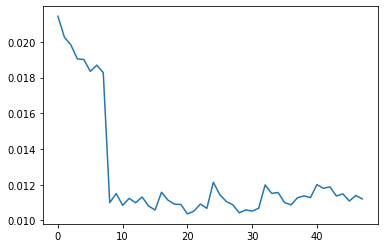

0.010367924347519875


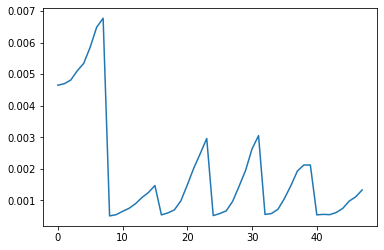

0.0005120153073221445


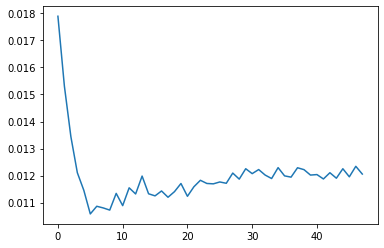

0.010581720620393753
0.5031849260026771 tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0006, grad_fn=<MseLossBackward>)


In [25]:
plt.plot(cpn_losses)
plt.show()
print(min(cpn_losses))

plt.plot(pred_losses)
plt.show()
print(min(pred_losses))

plt.plot(real_losses)
plt.show()
print(min(real_losses))

mrl = min(real_losses)
dh = mrl - comp_loss_healthy.item()
dl = comp_loss_lesioned.item() - comp_loss_healthy.item()
recov_pct = 1.0 - (dh / dl)
print(recov_pct, comp_loss_lesioned, comp_loss_healthy)

In [26]:
# TODO: get a CPN collection and explore the impact of the level of noise we are using.
# TODO: look for classes or data points we suck at
# TODO: train vs test
# TODO: deep dive EN grads bad

print(recent_losses)

[0.012536630965769291, 0.012541639618575573]


torch.Size([1, 341, 50])


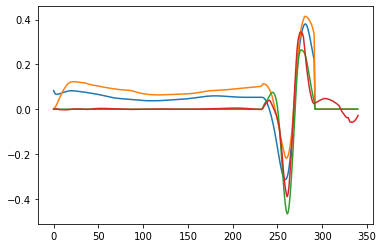

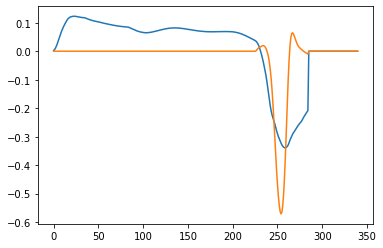

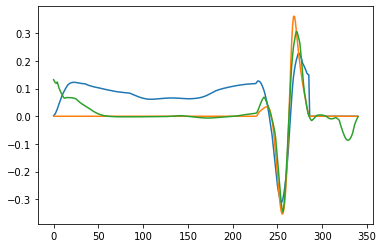

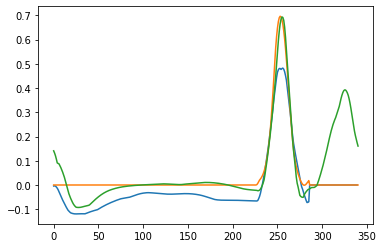

In [27]:
mike.reset()
reference_pred_lesioned_0 = mike.unroll(din[0, :, :].T)
reference_pred_lesioned_neg1 = mike.unroll(din[-1, :, :].T)
reference_pred_lesioned_20 = mike.unroll(din[20, :, :].T)
mike.reset()

print(reference_pred_lesioned_0.shape)


plt.plot(preds[0, :, 45].detach().numpy())
#plt.plot(preds.grad[0, :, 45].detach().numpy())
plt.plot(actuals[0, :, 45].detach().numpy())
plt.plot(dout[0, :, 45].detach().numpy())
plt.plot(reference_pred_lesioned_0[0, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[-1, :, 45].detach().numpy())
plt.plot(actuals[-1, :, 45].detach().numpy())
plt.plot(dout[-1, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[20, :, 45].detach().numpy())
plt.plot(actuals[20, :, 45].detach().numpy())
plt.plot(dout[20, :, 45].detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[20, :, 7].detach().numpy())
plt.plot(actuals[20, :, 7].detach().numpy())
plt.plot(dout[20, :, 7].detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 7].detach().numpy())
plt.show()

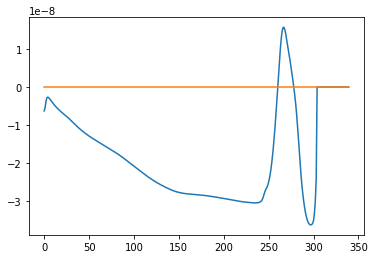

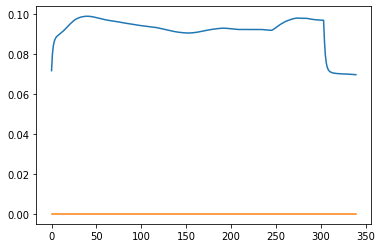

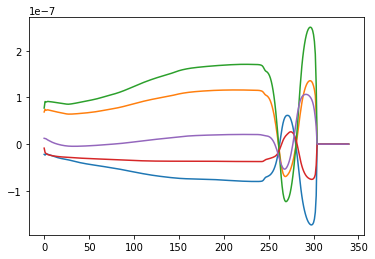

In [44]:
ss = [x[20, 6].item() for x in stims]
gg = [x.grad[20, 6].item() for x in stims]
ref = [0.0 for x in stims]

plt.plot(gg)
plt.plot(ref)
plt.show()
plt.plot(ss)
plt.plot(ref)
plt.show()

for idx in range(0, 25, 5):
    gg = [x.grad[20, idx].item() for x in stims]
    plt.plot(gg)
plt.show()

# On bad run: gradient is negative when values are too high

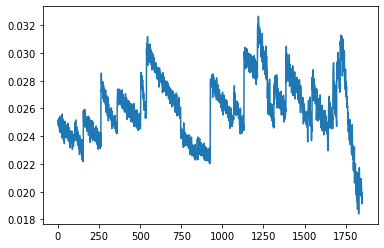

In [12]:
plt.plot(cpn_losses)